# **Deep Learning Final Project**
 **Submitters: <br>Rawan Awawde <br>
Elinor Bengayev**

**Project definition:** <br>
Our dataset is of an Online Retail store, that contains all the transactions occurring for a UK-based and registered, online retail data. The company mainly sells unique all-occasion gift-ware. <br>
We had two data sets of this store: <br>
01/12/2009 – 09/12/2010 <br>
01/12/2010  - 09/12/2011 <br>
Our goal is to forecast the number of sold products during the year of 2011 according to 2010 data set.



### **Loading the data and importing libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV, train_test_split
import xgboost as xgb
from tqdm.notebook import tqdm as notebook_tqdm
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Input, Flatten, LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from keras.layers import Dense, Flatten, Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
from itertools import cycle
import gc
from sklearn import preprocessing
from statistics import mean
from os.path import exists

#### **Preparing the data**

**Attribute Information:** <br>
InvoiceNo: Invoice number. Nominal. A 6-digit integral number uniquely assigned to each transaction.  <br>
StockCode: Product (item) code. Nominal. A 5-digit integral number uniquely assigned to each distinct product. <br>
Description: Product (item) name. Nominal. <br>
Quantity: The quantities of each product (item) per transaction. Numeric. <br>
InvoiceDate: Invice date and time. Numeric. The day and time when a transaction was generated. <br>
UnitPrice: Unit price. Numeric. Product price per unit in sterling (Â£). <br>
CustomerID: Customer number. Nominal. A 5-digit integral number uniquely assigned to each customer.<br>
Country: Country name. Nominal. The name of the country where a customer resides.



We noticed that the first dataset 2009-2010 contains only one month in year 2009 but we want to forecast a complete year "2011", so we need more data. <br>
We imported more csv '2010-2011' in order to overcome this issue and to have equal number of months for both years.<br>


In [3]:
df_0910 = pd.read_csv('/content/drive/MyDrive/DeepLearningProject/Year 2009-2010.csv', encoding= 'unicode_escape') 
df_1011 = pd.read_csv('/content/drive/MyDrive/DeepLearningProject/Year 2010-2011.csv', encoding= 'unicode_escape') 
df10=df_0910.copy()
df11=df_1011.copy()

**Merging the dataframes with relevant months** <br>
Our train set is from 01-12-2009 untill 31-12-2010 (df10) <br>
Our test set is from 01-01-2011 untill 31-12-2011 (df11)<br>


In [4]:
def change_df(df):
  df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
  df['Date'] = df['InvoiceDate'].dt.date
change_df(df10)
change_df(df11)

In [5]:
start10 = pd.to_datetime('2009-12-01').date()
end10 = pd.to_datetime('2010-11-30').date()
df10=df10.loc[(df10['Date'] >= start10) & (df10['Date'] <= end10)] #this dataframe contains all relevant months from 2009-2010 file
start11 = pd.to_datetime('2010-12-01').date()
end11 = pd.to_datetime('2010-12-31').date()
start = pd.to_datetime('2011-01-01').date()
end = pd.to_datetime('2011-12-31').date()
dfdec = df11.loc[(df11['Date'] >= start11) & (df11['Date'] <= end11)] #taking december 2010 from df11
df11 = df11.loc[(df11['Date'] >= start) & (df11['Date'] <= end)] #df11 contains all months for 2011
df10 = df10.append(dfdec,ignore_index=True) #adding december 2010 from df11 into df10

**Checking if the products are the same in both years:** <br>
Because we want to forecast the quantity of products in 2011 based on the quantity of the same products in 2010, we would like to check the existence of the same products in each year.<br>
After this check we noticed that there are products in 2011 that aren't in 2010 so later we will filter them. 

In [6]:
# def check_products(df1,df2):
#   products_names1=df1['StockCode'].unique()
#   products_names2=df2['StockCode'].unique()
#   count=0
#   for name in products_names1:
#     if name not in products_names2:
#        count+=1
#        df1.drop(df1[df1.StockCode == name].index, inplace=True)
#       #  df1=df1.drop(rows)
#   print(count)
#   # return count

# check_products(df10,df11)
# check_products(df11,df10)

### **Exploration**

This is how the data looks like for one product: 

In [7]:
df10.query('StockCode == "21232"')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Date
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009-12-01
231,489461,21232,STRAWBERRY CERAMIC TRINKET BOX,48,2009-12-01 10:49:00,1.25,17865.0,United Kingdom,2009-12-01
841,489536,21232,STRAWBERRY CERAMIC TRINKET BOX,3,2009-12-01 12:13:00,1.25,16393.0,United Kingdom,2009-12-01
910,489537,21232,STRAWBERRY CERAMIC TRINKET BOX,20,2009-12-01 12:14:00,1.25,14040.0,United Kingdom,2009-12-01
1004,489546,21232,STRAWBERRY CERAMIC TRINKET BOX,12,2009-12-01 12:30:00,1.25,14156.0,EIRE,2009-12-01
...,...,...,...,...,...,...,...,...,...
541467,539580,21232,STRAWBERRY CERAMIC TRINKET BOX,12,2010-12-20 12:51:00,1.25,15312.0,United Kingdom,2010-12-20
541992,539628,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2010-12-20 14:49:00,1.25,18097.0,United Kingdom,2010-12-20
542377,C539644,21232,STRAWBERRY CERAMIC TRINKET BOX,-2,2010-12-20 15:52:00,1.25,12471.0,Germany,2010-12-20
542380,C539644,21232,STRAWBERRY CERAMIC TRINKET BOX,-4,2010-12-20 15:52:00,1.25,12471.0,Germany,2010-12-20


**View the top 10 purchasing countries**

Text(0.5, 1.0, 'Country')

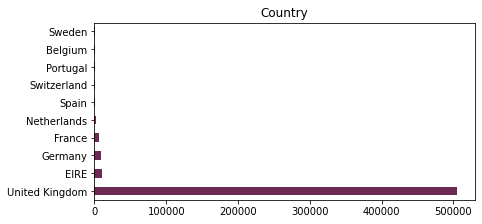

In [8]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(4,2,1)
ax = df10['Country'].value_counts().head(10).plot.barh(color = '#6d2a55')
ax.set_title('Country')

We can see that most of the orders were made in the UK


**Exploring the data by orders** <br>
Creating an orders dataframe by the 'Invoice' attribute

In [9]:
df10.rename(columns={'Customer ID': 'CustomerID'}, inplace = True)
df11.rename(columns={'Customer ID': 'CustomerID'}, inplace = True)

In [10]:
order_df = pd.DataFrame()
new_row = dict({'Invoice': df10.iloc[0]['Invoice'], 'Quantity': df10.iloc[0]['Quantity'], 'InvoiceDate': df10.iloc[0]['InvoiceDate'],
       'Price': df10.iloc[0]['Price'], 'CustomerID': df10.iloc[0]['CustomerID'], 'Country': df10.iloc[0]['Country']})
for row in df10.itertuples():
  if row.Index == 0:
    continue
  if(row.Invoice is new_row['Invoice']):
    new_row['Quantity'] = new_row['Quantity'] + row.Quantity
    new_row['Price'] = new_row['Price'] + row.Price
  else:
    order_df = order_df.append(new_row, ignore_index = True)
    new_row = dict({'Invoice': row.Invoice, 'Quantity': row.Quantity, 'InvoiceDate': row.InvoiceDate,
       'Price': row.Price, 'CustomerID': row.CustomerID, 'Country': row.Country})

**Creating datetime features to explore the data across time**

In [11]:
def create_time_features(df, label=None):
    df['hour'] = df['InvoiceDate'].dt.hour
    df['dayofweek'] = df['InvoiceDate'].dt.dayofweek
    df['quarter'] = df['InvoiceDate'].dt.quarter
    df['month'] = df['InvoiceDate'].dt.month
    df['year'] = df['InvoiceDate'].dt.year
    df['dayofyear'] = df['InvoiceDate'].dt.dayofyear
    df['dayofmonth'] = df['InvoiceDate'].dt.day
    df['weekofyear'] = (df['InvoiceDate'].dt.isocalendar().week).apply(lambda a: int(a))
    df['Date']=df['InvoiceDate'].dt.date

In [12]:
create_time_features(order_df)
order_df

,Invoice,Quantity,InvoiceDate,Price,CustomerID,Country,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Date
0,489434,166.0,2009-12-01 07:45:00,32.65,13085.0,United Kingdom,7,1,4,12,2009,335,1,49,2009-12-01
1,489435,60.0,2009-12-01 07:46:00,10.50,13085.0,United Kingdom,7,1,4,12,2009,335,1,49,2009-12-01
2,489436,193.0,2009-12-01 09:06:00,70.88,13078.0,United Kingdom,9,1,4,12,2009,335,1,49,2009-12-01
3,489437,145.0,2009-12-01 09:08:00,83.45,15362.0,United Kingdom,9,1,4,12,2009,335,1,49,2009-12-01
4,489438,826.0,2009-12-01 09:24:00,44.05,18102.0,United Kingdom,9,1,4,12,2009,335,1,49,2009-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30435,539987,1.0,2010-12-23 15:32:00,6.95,12748.0,United Kingdom,15,3,4,12,2010,357,23,51,2010-12-23
30436,539988,178.0,2010-12-23 16:06:00,221.31,18116.0,United Kingdom,16,3,4,12,2010,357,23,51,2010-12-23
30437,539989,1.0,2010-12-23 16:16:00,3.75,NaN,United Kingdom,16,3,4,12,2010,357,23,51,2010-12-23
30438,539990,17.0,2010-12-23 16:31:00,21.60,NaN,United Kingdom,16,3,4,12,2010,357,23,51,2010-12-23


**Plotting the order_df by time features**

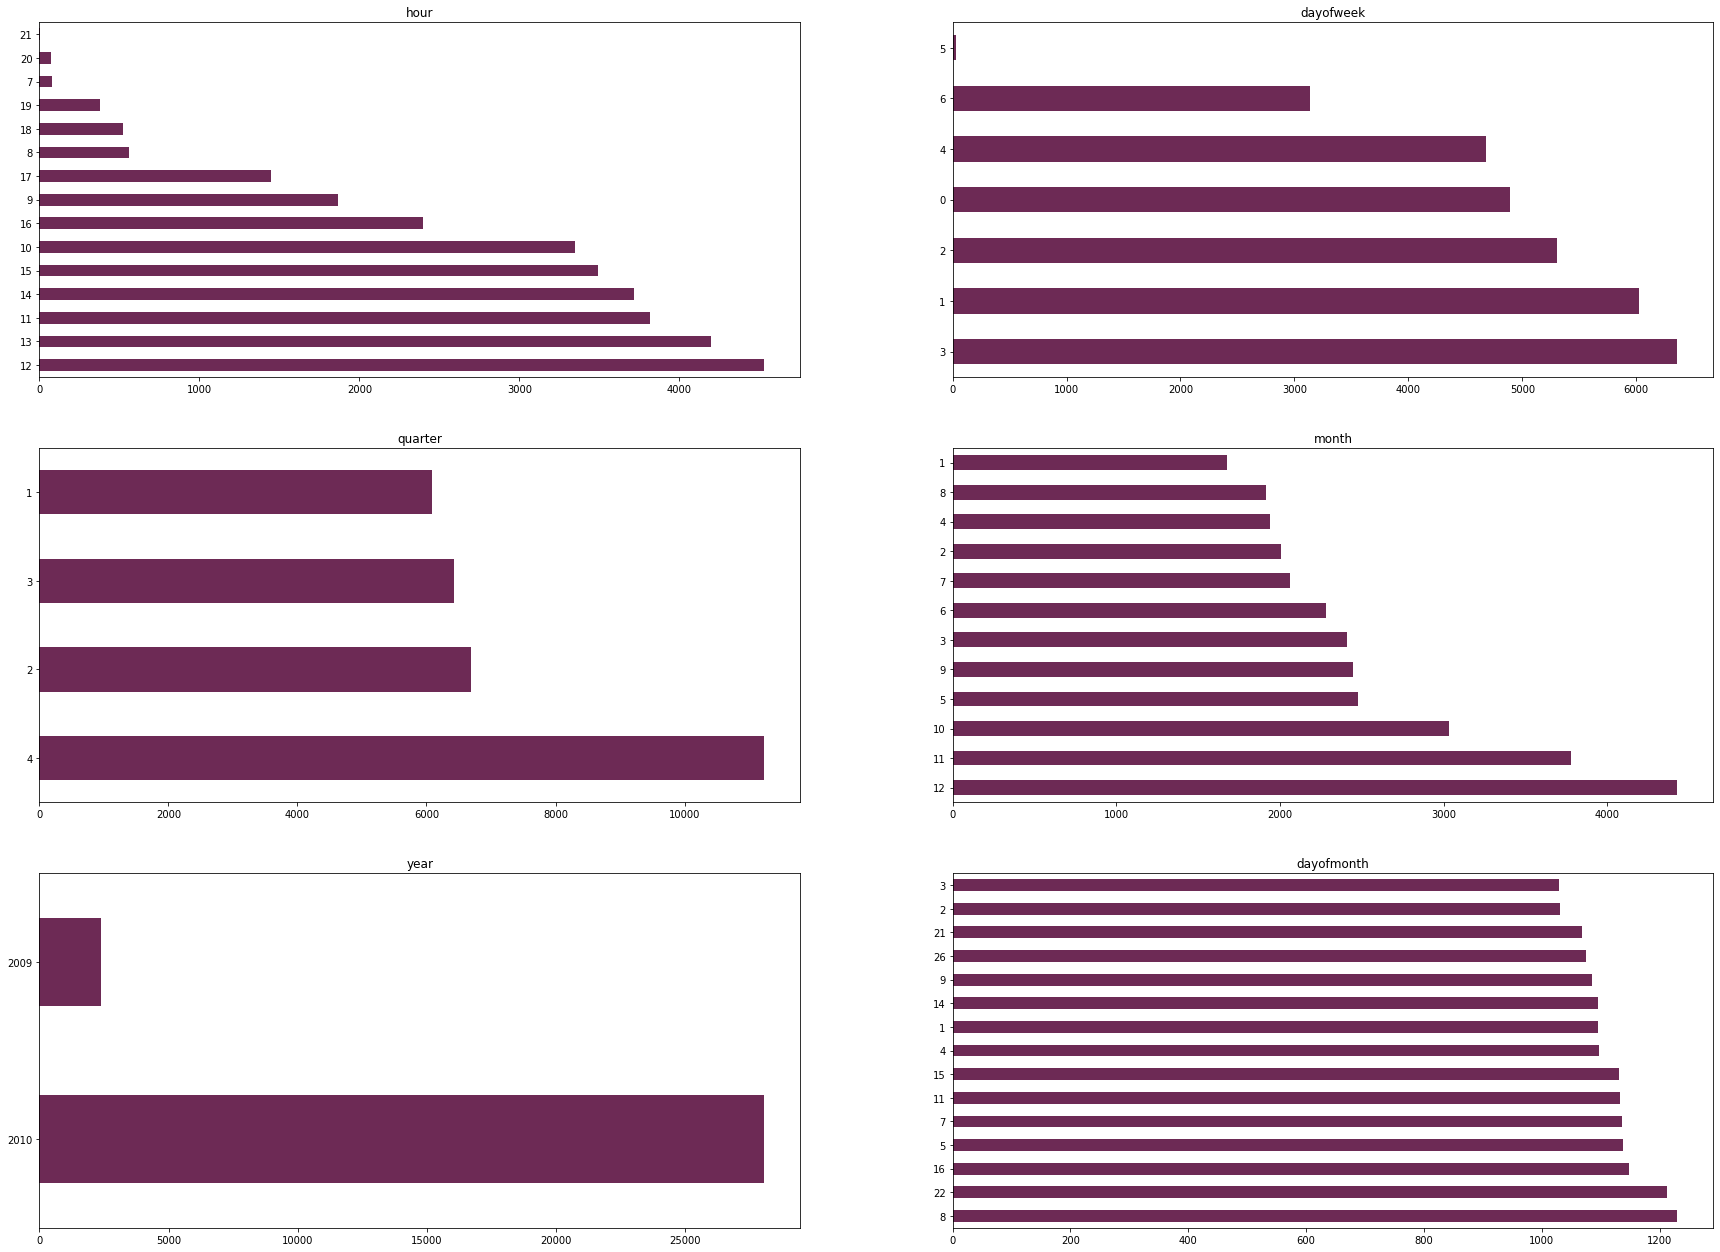

In [13]:
date_time_features =  order_df[['hour','dayofweek','quarter','month','year', 'dayofmonth']]
fig = plt.figure(figsize = (30,30))
for i, col in enumerate(date_time_features):
  ax = fig.add_subplot(4,2,i+1)
  ax = order_df[col].value_counts().head(15).plot.barh(color = '#6d2a55')
  ax.set_title(col)

From the plots we can see that most purchases were placed on Tuesdays, at noon hours, in the 8 day of the month and on December month (Holidays season)

**Checking how many different customers are buying per day**

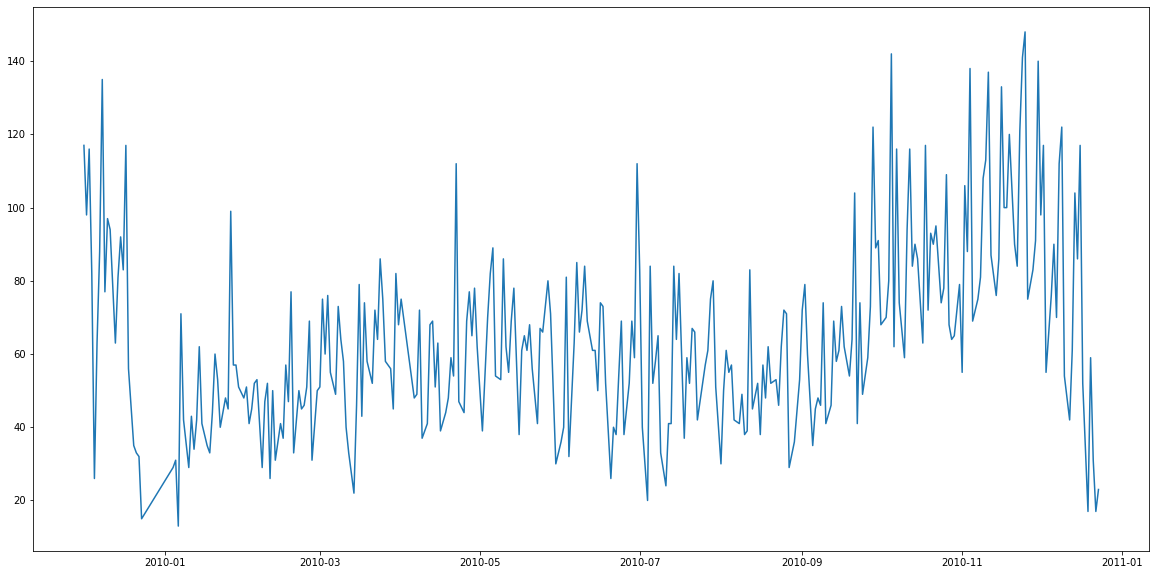

In [14]:
grouped_customer = df10[['CustomerID','Date']].groupby(['Date']).nunique().sort_values('Date').reset_index()
plt.figure(figsize=(20,10))
plt.plot(grouped_customer['Date'],grouped_customer['CustomerID'])
plt.show()

**Checking how many customers return in the same day with different invoice**
<br> Different invoice: different order

In [15]:
returning_customers_df = order_df[['Invoice','CustomerID','year']].groupby(['CustomerID','year']).count()
returning_customers_df = returning_customers_df.reset_index()

In [16]:
returning_count=0
not_returning_count=0
returning_customers_df['Return'] = 0
for index, row in  returning_customers_df.iterrows():
  if row['Invoice'] > 1 :
    returning_customers_df.loc[index,'Return'] = 1
    returning_count = returning_count+1
  else :
    not_returning_count = not_returning_count+1
print ('Num of customers that returned more than once in same year with different invoice:', returning_count)
print ('Num of customers that didn\'t return in the same year with different invoice:', not_returning_count)

Num of customers that returned more than once in same year with different invoice: 3505
Num of customers that didn't return in the same year with different invoice: 1829


In [17]:
Return_graph = px.pie(returning_customers_df, values=returning_customers_df['Return'].value_counts().values, names=returning_customers_df['Return'].value_counts().index,
             title='The percentage of customers that return in the same day with different invoice' , color_discrete_sequence=px.colors.sequential.Peach)
Return_graph.update_traces(textposition='inside', textinfo='percent+label')
Return_graph.show()

**Checking the number of returned customers with different invoice per month**




In [18]:
returning_customer_month = order_df[['Invoice','CustomerID','Date']].groupby(['CustomerID','Date']).size().reset_index(name='counts')

Text(0, 0.5, 'returns')

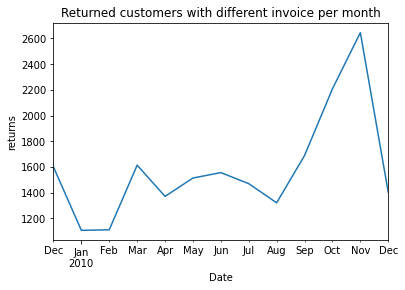

In [19]:
date_idx = returning_customer_month.set_index('Date')
date_idx.index = pd.to_datetime(date_idx.index, errors='coerce')
month_ret = date_idx.index.to_period("M")
month_ret = date_idx.resample("M").size()
s=month_ret.plot(title='Returned customers with different invoice per month')
s.set_ylabel('returns')

**Top bought products**

In [20]:
top_products = df10[['StockCode','Price','Invoice','Date','Quantity']].groupby(['StockCode','Price','Date','Quantity']).count()
top_products = top_products.reset_index()
top_products.sort_values(by=['Invoice'],ascending=False)

,StockCode,Price,Date,Quantity,Invoice
44920,21034,0.95,2010-11-24,1,18
102096,21509,0.36,2010-07-05,12,16
170892,22023,0.36,2010-07-05,12,16
101117,21504,0.36,2010-07-05,12,16
101839,21508,0.36,2010-07-05,12,16
...,...,...,...,...,...
163209,21944,0.85,2010-07-08,2,1
163208,21944,0.85,2010-06-28,2,1
163207,21944,0.85,2010-06-16,12,1
163206,21944,0.85,2010-06-15,12,1


We can see that the most purchased product is REX CASH+CARRY JUMBO SHOPPER with stock code <br >'21034'

Deleting unnecessary data frames :

In [21]:
del top_products,date_idx,month_ret,returning_customer_month,Return_graph,returning_customers_df,grouped_customer,order_df
gc.collect()

2559

### **Preprocessing**

In [22]:
df10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545419 entries, 0 to 545418
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      545419 non-null  object        
 1   StockCode    545419 non-null  object        
 2   Description  542473 non-null  object        
 3   Quantity     545419 non-null  int64         
 4   InvoiceDate  545419 non-null  datetime64[ns]
 5   Price        545419 non-null  float64       
 6   CustomerID   429581 non-null  float64       
 7   Country      545419 non-null  object        
 8   Date         545419 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 37.5+ MB


**Checking for invalid records**

In [23]:
df10.query('Quantity < 0 or Price == 0.0')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,Date
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,2009-12-01
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia,2009-12-01
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia,2009-12-01
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia,2009-12-01
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,2009-12-01
...,...,...,...,...,...,...,...,...,...
544561,C539950,85099B,JUMBO BAG RED RETROSPOT,-10,2010-12-23 11:50:00,1.95,13534.0,United Kingdom,2010-12-23
544562,C539950,22720,SET OF 3 CAKE TINS PANTRY DESIGN,-2,2010-12-23 11:50:00,4.95,13534.0,United Kingdom,2010-12-23
544634,C539956,35004C,SET OF 3 COLOURED FLYING DUCKS,-15,2010-12-23 12:55:00,4.65,12980.0,United Kingdom,2010-12-23
545227,539980,35001W,NaN,-36,2010-12-23 14:34:00,0.00,NaN,United Kingdom,2010-12-23


We can see that those records are irregular and moreover CustomerID and description are Nan, so those records proabaly invalid so we will remove them from the train set. 

In [24]:
to_drop = df10.query('Quantity < 0 or Price == 0.0')
df10 = df10.drop(to_drop.index)

**Checking missing values**

Check for proportion of missing values per column




In [25]:
percent_missing = df10.isnull().sum() * 100 / len(df10)
missing_value_df = pd.DataFrame({'column_name': df10.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
Invoice,Invoice,0.000000
StockCode,StockCode,0.000000
Description,Description,0.000000
Quantity,Quantity,0.000000
InvoiceDate,InvoiceDate,0.000000
Price,Price,0.000000
Country,Country,0.000000
Date,Date,0.000000
CustomerID,CustomerID,21.037487


The best way for handling time series null data is to fill it with interpolation, but in our case the missing values are not in columns  that related to the prediction factors (Description, CustomerID), so we decided to drop them.

https://towardsdatascience.com/how-to-interpolate-time-series-data-in-apache-spark-and-python-pandas-part-1-pandas-cff54d76a2ea



In [26]:
df10 = df10.drop(columns = ['Description', 'CustomerID'])
df11 = df11.drop(columns = ['Description', 'CustomerID'])

#### **Feature Engeneering**

**Creating dummy variable is_uk** <br>
We have noticed that the most repeated country is UK so we decided to make a dummy variable is_uk and to drop the country column.

In [27]:
df10['is_uk'] = np.where(df10['Country'] == 'United Kingdom', 1, 0)
df11['is_uk'] = np.where(df11['Country'] == 'United Kingdom', 1, 0)

**Creating dummy variable is_christmas** <br>
According to https://financesonline.com/christmas-shopping-statistics/
the period between December 15 and 24 was predicted to account for 40% of all Christmas sales in 2020, so we assumed that this time period is also relevant to our data years. 


In [28]:
df10['InvoiceDate'] = pd.to_datetime(df10['InvoiceDate'], errors='coerce')
df11['InvoiceDate'] = pd.to_datetime(df11['InvoiceDate'], errors='coerce')

In [29]:
ch_start_09 = pd.to_datetime('2009-12-15').date()
ch_end_09 = pd.to_datetime('2009-12-24').date()
ch_start_10 = pd.to_datetime('2010-12-15').date()
ch_end_10 = pd.to_datetime('2010-12-24').date()
df10['is_christmas'] = np.where((df10['Date'] >= ch_start_09) & (df10['Date'] <= ch_end_09) | (df10['Date'] >= ch_start_10) & (df10['Date'] <= ch_end_10), 1, 0)

In [30]:
ch_start_11 = pd.to_datetime('2011-12-15').date()
ch_end_11 = pd.to_datetime('2011-12-24').date()
df11['is_christmas'] = np.where((df11['Date'] >= ch_start_11) & (df11['Date'] <= ch_end_11), 1, 0)

Checking if the is_christmas value is 0 in nan christmas dates




In [31]:
start_ten = pd.to_datetime('2010-12-18').date()
end_ten = pd.to_datetime('2010-12-28').date()
mask = (df10['Date'] >= start_ten) & (df10['Date'] <= end_ten)
df10.loc[mask]

,Invoice,StockCode,Quantity,InvoiceDate,Price,Country,Date,is_uk,is_christmas
540294,539461,37449,1,2010-12-19 10:21:00,9.95,United Kingdom,2010-12-19,1,1
540295,539461,22314,3,2010-12-19 10:21:00,2.95,United Kingdom,2010-12-19,1,1
540296,539461,72801G,12,2010-12-19 10:21:00,1.25,United Kingdom,2010-12-19,1,1
540297,539461,22988,12,2010-12-19 10:21:00,1.25,United Kingdom,2010-12-19,1,1
540298,539461,82494L,6,2010-12-19 10:21:00,2.95,United Kingdom,2010-12-19,1,1
...,...,...,...,...,...,...,...,...,...
545414,539991,21618,1,2010-12-23 16:49:00,1.25,United Kingdom,2010-12-23,1,1
545415,539991,72741,4,2010-12-23 16:49:00,1.45,United Kingdom,2010-12-23,1,1
545416,539992,21470,1,2010-12-23 17:41:00,3.75,United Kingdom,2010-12-23,1,1
545417,539992,22258,1,2010-12-23 17:41:00,1.25,United Kingdom,2010-12-23,1,1


It's known that Black Friday and Cyber Monday are both popular dates for shopping, so we decided to make dummy variables for them.

**Creating dummy variable for Black Friday "is_bf"** <br>


In [32]:
bf_start_10 = pd.to_datetime('2010-11-26').date()
df10['is_bf'] = np.where(df10['Date'] == bf_start_10, 1, 0)

bf_start_11 = pd.to_datetime('2011-11-25').date()
df11['is_bf'] = np.where(df11['Date'] == bf_start_11, 1, 0)

**Creating dummy variable for Cyber Monday "is_cm"** <br>


In [33]:
cm_start_10 = pd.to_datetime('2010-11-29').date()
df10['is_cm'] = np.where(df10['Date'] == cm_start_10, 1, 0)

cm_start_11 = pd.to_datetime('2011-11-28').date()
df11['is_cm'] = np.where(df11['Date'] == cm_start_11, 1, 0)

**Creating time features** <br>

In [34]:
create_time_features(df10)
create_time_features(df11)


**Creating season column** <br>
We assumed that the amount of purchases is also related to the current season, so we encoded the seasons into numbers and added them as attribute.

In [35]:
# create a list of our conditions
def return_season_conditions_list(df):
  conditions = [
      (df['weekofyear'] > 0) & (df['weekofyear'] <= 9) | (df['weekofyear'] > 48) & (df['weekofyear'] <= 53),
      (df['weekofyear'] > 9) & (df['weekofyear'] <= 21),
      (df['weekofyear'] > 21) & (df['weekofyear'] <= 34),
      (df['weekofyear'] > 34) & (df['weekofyear'] <= 48)
      ]
  return conditions

# create a list of the values we want to assign for each condition
values = [0, 1, 2, 3]
df10_conditions = return_season_conditions_list(df10)
df11_conditions = return_season_conditions_list(df11)

# create a new column and use np.select to assign values to it using our lists as arguments
df10['season'] = np.select(df10_conditions, values)
df11['season'] = np.select(df11_conditions, values)

# display updated DataFrame
df10.head(100000)

,Invoice,StockCode,Quantity,InvoiceDate,Price,Country,Date,is_uk,is_christmas,is_bf,is_cm,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season
0,489434,85048,12,2009-12-01 07:45:00,6.95,United Kingdom,2009-12-01,1,0,0,0,7,1,4,12,2009,335,1,49,0
1,489434,79323P,12,2009-12-01 07:45:00,6.75,United Kingdom,2009-12-01,1,0,0,0,7,1,4,12,2009,335,1,49,0
2,489434,79323W,12,2009-12-01 07:45:00,6.75,United Kingdom,2009-12-01,1,0,0,0,7,1,4,12,2009,335,1,49,0
3,489434,22041,48,2009-12-01 07:45:00,2.10,United Kingdom,2009-12-01,1,0,0,0,7,1,4,12,2009,335,1,49,0
4,489434,21232,24,2009-12-01 07:45:00,1.25,United Kingdom,2009-12-01,1,0,0,0,7,1,4,12,2009,335,1,49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103184,499246,22497,1,2010-02-25 13:40:00,8.47,United Kingdom,2010-02-25,1,0,0,0,13,3,1,2,2010,56,25,8,0
103185,499246,35004C,1,2010-02-25 13:40:00,12.72,United Kingdom,2010-02-25,1,0,0,0,13,3,1,2,2010,56,25,8,0
103186,499246,37333,1,2010-02-25 13:40:00,11.02,United Kingdom,2010-02-25,1,0,0,0,13,3,1,2,2010,56,25,8,0
103187,499246,37449,2,2010-02-25 13:40:00,21.23,United Kingdom,2010-02-25,1,0,0,0,13,3,1,2,2010,56,25,8,0


**Creating part of the day column** <br>
The same assumption as above.

In [36]:
# create a list of our conditions
def return_hour_conditions_list(df):
  conditions = [
      (df['hour'] >= 6) & (df['hour'] <= 12),
      (df['hour'] > 12) & (df['hour'] <= 18),
      (df['hour'] > 18) & (df['hour'] <= 21)
      ]
  return conditions

# create a list of the values we want to assign for each condition
values = [0, 1, 2]
df10_conditions = return_hour_conditions_list(df10)
df11_conditions = return_hour_conditions_list(df11)

# create a new column and use np.select to assign values to it using our lists as arguments
df10['part_of_day'] = np.select(df10_conditions, values)
df11['part_of_day'] = np.select(df11_conditions, values)

# display updated DataFrame
df10.head(100000)

,Invoice,StockCode,Quantity,InvoiceDate,Price,Country,Date,is_uk,is_christmas,is_bf,...,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,part_of_day
0,489434,85048,12,2009-12-01 07:45:00,6.95,United Kingdom,2009-12-01,1,0,0,...,7,1,4,12,2009,335,1,49,0,0
1,489434,79323P,12,2009-12-01 07:45:00,6.75,United Kingdom,2009-12-01,1,0,0,...,7,1,4,12,2009,335,1,49,0,0
2,489434,79323W,12,2009-12-01 07:45:00,6.75,United Kingdom,2009-12-01,1,0,0,...,7,1,4,12,2009,335,1,49,0,0
3,489434,22041,48,2009-12-01 07:45:00,2.10,United Kingdom,2009-12-01,1,0,0,...,7,1,4,12,2009,335,1,49,0,0
4,489434,21232,24,2009-12-01 07:45:00,1.25,United Kingdom,2009-12-01,1,0,0,...,7,1,4,12,2009,335,1,49,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103184,499246,22497,1,2010-02-25 13:40:00,8.47,United Kingdom,2010-02-25,1,0,0,...,13,3,1,2,2010,56,25,8,0,1
103185,499246,35004C,1,2010-02-25 13:40:00,12.72,United Kingdom,2010-02-25,1,0,0,...,13,3,1,2,2010,56,25,8,0,1
103186,499246,37333,1,2010-02-25 13:40:00,11.02,United Kingdom,2010-02-25,1,0,0,...,13,3,1,2,2010,56,25,8,0,1
103187,499246,37449,2,2010-02-25 13:40:00,21.23,United Kingdom,2010-02-25,1,0,0,...,13,3,1,2,2010,56,25,8,0,1


Another way of encoding we've tried.

In [37]:
# le = preprocessing.LabelEncoder()
# df10['season'] = le.fit_transform(df10['season'])
# df11['season'] = le.transform(df11['season'])

In [38]:
# le = preprocessing.LabelEncoder()
# df10['part_of_day'] = le.fit_transform(df10['part_of_day'])
# df11['part_of_day'] = le.transform(df11['part_of_day'])

**Create aggregated features**

At first, we tried to create the aggreted features by days. After some experiments we have seen that by hours gives better resuts, so we've decided to create them by hours.

In [39]:
# def group_df_by_date(df, stockcode=None):
#   columns = ['Date','is_uk',	'is_christmas',	'is_bf',	'is_cm','dayofweek',	'quarter',	'month',	'year',	'dayofyear',
#       'dayofmonth',	'weekofyear',	'season', 'part_of_day']
#   f = {'Quantity': 'sum', 'Price':'mean'}
#   if stockcode:  
#     columns.append('StockCode')
#   df = df.groupby(columns).agg(f)
#   df.rename(columns = {'Price': 'avg_price'}, inplace=True)
#   return df

In [40]:
# def create_aggregate_features(df):
#   df['mean_3d'] = df['Quantity'].shift(1).rolling(3).mean()
#   df['mean_7d'] = df['Quantity'].shift(1).rolling(7).mean()
#   df['mean_30d'] = df['Quantity'].shift(1).rolling(30).mean()
#   df = df.fillna(0.0)
#   return df

In [41]:
def group_df_by_hour(df, stockcode=None):
  columns = ['InvoiceDate', 'hour', 'is_uk',	'is_christmas',	'is_bf',	'is_cm','dayofweek',	'quarter',	'month',	'year',	'dayofyear',
      'dayofmonth',	'weekofyear',	'season', 'part_of_day']
  f = {'Quantity': 'sum', 'Price':'mean'}
  if stockcode:  
    columns.append('StockCode')
  df = df.groupby(columns).agg(f)
  df.rename(columns = {'Price': 'avg_price'}, inplace=True)
  return df

In [42]:
def create_aggregate_features_by_hour(df):
  df['mean_3h'] = df['Quantity'].shift(1).rolling(3).mean()
  df['mean_9h'] = df['Quantity'].shift(1).rolling(9).mean()
  df['mean_30h'] = df['Quantity'].shift(1).rolling(30).mean()
  df = df.fillna(0.0)
  return df

In [43]:
df10['InvoiceDate'] = df10['InvoiceDate'].apply(lambda x: x.replace(minute=0, second=0, microsecond=0))

**Outliers** <br>
Deleting rows from the test set is not allowed, so we only handle train set.

In [44]:
outliers = ['Quantity', 'Price']
for col in outliers:
    mean = df10[col].mean()
    std = df10[col].std(ddof = 0)
    z_scores_train = (df10[col] - mean)/(std)
    df10 = df10[z_scores_train < 5]

**From now we continue to work with a copy of df10/df11 so we can have refrence to the original df** 





In [45]:
df10_copy = df10.copy()
df11_copy = df11.copy()

#### **Working strategies <br> we thought about 2 different ways for training the models:** <br>

1.   Training and testing the models on the whole data frames
2.   Splitting the data frames to products, training and testing the models on the relevant data frames for each product 

We suggested these ways because we assumed that the models will learn the features differently in each situation.



**First method:** 
<br>
Training on whole data set

Feature engineering for the whole data:

In [46]:
df10_copy = group_df_by_hour(df10_copy)
df11_copy = group_df_by_hour(df11_copy)
df10_copy = create_aggregate_features_by_hour(df10_copy)
df11_copy = create_aggregate_features_by_hour(df11_copy)

In [47]:
df10_copy = df10_copy.reset_index()
df11_copy = df11_copy.reset_index()

df10_copy['InvoiceDate'] = pd.to_datetime(df10_copy['InvoiceDate'], format='%Y-%m-%d')
df11_copy['InvoiceDate'] = pd.to_datetime(df11_copy['InvoiceDate'], format='%Y-%m-%d')

df10_copy = df10_copy.set_index('InvoiceDate')
df11_copy = df11_copy.set_index('InvoiceDate')

In [48]:
df10_copy

,hour,is_uk,is_christmas,is_bf,is_cm,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,part_of_day,Quantity,avg_price,mean_3h,mean_9h,mean_30h
InvoiceDate,,,,,,,,,,,,,,,,,,,
2009-12-01 07:00:00,7,1,0,0,0,1,4,12,2009,335,1,49,0,0,226,3.595833,0.000000,0.000000,0.000000
2009-12-01 09:00:00,9,0,0,0,0,1,4,12,2009,335,1,49,0,0,220,10.432000,0.000000,0.000000,0.000000
2009-12-01 09:00:00,9,1,0,0,0,1,4,12,2009,335,1,49,0,0,1957,2.872456,0.000000,0.000000,0.000000
2009-12-01 10:00:00,10,0,0,0,0,1,4,12,2009,335,1,49,0,0,101,15.020000,801.000000,0.000000,0.000000
2009-12-01 10:00:00,10,1,0,0,0,1,4,12,2009,335,1,49,0,0,1880,3.499098,759.333333,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-23 14:00:00,14,0,1,0,0,3,4,12,2010,357,23,51,0,1,108,6.133333,1134.666667,499.777778,769.333333
2010-12-23 14:00:00,14,1,1,0,0,3,4,12,2010,357,23,51,0,1,806,2.455000,880.000000,511.555556,750.733333
2010-12-23 15:00:00,15,1,1,0,0,3,4,12,2010,357,23,51,0,1,395,3.330588,1078.000000,571.333333,751.266667


 **Pearson Correlation Matrix**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



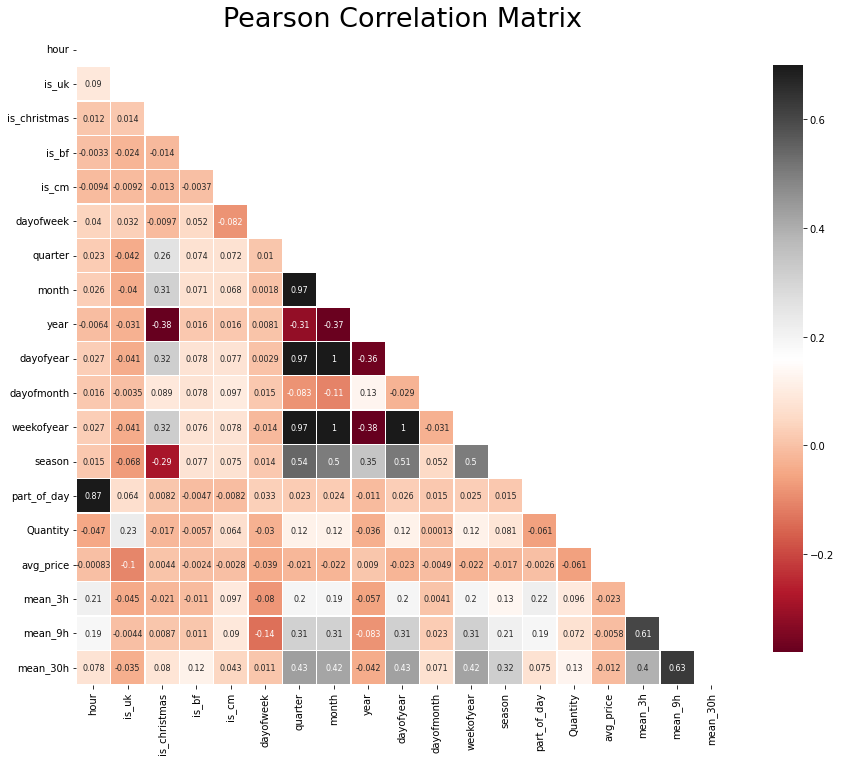

In [49]:
features = df10_copy.columns
mask = np.zeros_like(df10_copy[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 
f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=27)
sns.heatmap(df10_copy[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="RdGy", 
linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

From the matrix, we can see that the highest correlation features with our target column - Quantity, are is_uk feature and time features ones, specifically - quarter, month and dayofyear. They all indicates the time of the year. 

**Splitting the data**

In [107]:
columns = ['avg_price','is_uk','is_christmas','is_bf','is_cm','dayofweek','quarter','month',
                             'dayofyear','dayofmonth','weekofyear','season', 'part_of_day','mean_3h','mean_9h','mean_30h']
X_train, y_train = df10_copy[columns] ,df10_copy['Quantity']
X_test, y_test = df11_copy[columns] ,df11_copy['Quantity']

Checking the shapes of the data:

In [108]:
print('Shape of X_train is:', X_train.shape)
print('Shape of Y_train is:', y_train.shape)
print('Shape of X_test is:', X_test.shape)
print('Shape of Y_test is:', y_test.shape)

Shape of X_train is: (4166, 16)
Shape of Y_train is: (4166,)
Shape of X_test is: (21797, 16)
Shape of Y_test is: (21797,)


Splitting the train data into test and validation for the neural network models:


In [52]:
X_train_nn, X_val_nn, Y_train_nn, Y_val_nn = \
        train_test_split(X_train, y_train, train_size=0.8, random_state=42)
X_train_nn = X_train_nn.sort_index()
X_val_nn = X_val_nn.sort_index()
Y_train_nn = Y_train_nn.sort_index()
Y_val_nn = Y_val_nn.sort_index()

**Normalization**

We've tried to normalize the data for the NN models, but we saw some bad perfromance after it, so we've decided to skip this step. 

In [53]:
min_max_scaler = preprocessing.MinMaxScaler()
def scale_data_train(data, columns, scaler):
      for col in columns:
          data.loc[:,col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
def scale_data_test(data, columns, scaler):
      for col in columns:
        data.loc[:,col] = scaler.transform(data[col].values.reshape(-1, 1))

In [54]:
# scale_data_train(X_train_nn, X_train_nn.select_dtypes(include='number'), min_max_scaler)
# scale_data_test(X_val_nn, X_val_nn.select_dtypes(include='number'), min_max_scaler)

# scale_data_test(X_test_nn, X_test_nn.select_dtypes(include='number'), min_max_scaler)

In [109]:
X_test_nn = X_test.copy()

**Preparing dictionaries for storing the models' results**

In [56]:
models = {}
predictions_whole_data = {}
predictions_mini_datas_xgb = {}
predictions_mini_datas_fc = {}
predictions_mini_datas_lstm = {}
rmse_dict = {}
mae_dict = {}

#### **Models** <br>
We trained all models and saved them as files in our drive directory, afterwards we loaded them and computed all the predictions and results. <br>
In this way we saved training time, especially because we have a lot of mini data frames for products. <br>
We created train and load functions for XGB models and NN models separately.

**XGBoost Model**

We've ran GridSearchCV snd got those following parameters as the best ones.

In [57]:
def train_xgb(X_train,y_train,X_test,y_test, name, stockcode = None):
  # params = {'max_depth': [5, 10],
  #           'learning_rate': [0.3, 0.15],
  #           'gamma': [0.0, 0.1]}
  # xgb_model = GridSearchCV(estimator = xgb_model, 
  #                   param_grid = params,
  #                   scoring = 'neg_root_mean_squared_error',
  #                   cv = 3,
  #                   verbose = 30,
  #                   refit = True)

  xgb_model = xgb.XGBRegressor(n_estimators=200, objective='reg:squarederror', max_depth = 8, learning_rate = 0.15, gamma = 0.1)
  
  xgb_model.fit(X_train, y_train)
  xgb_model.save_model("/content/drive/MyDrive/DeepLearningProject/Project/assets/"+name)
  y_pred = xgb_model.predict(X_test)
  models['Regular XGBoost'] = xgb_model
  if stockcode == None:
    predictions_whole_data['Regular XGBoost'] = y_pred
  else: 
    predictions_mini_datas_xgb[stockcode] = y_pred
  return np.sqrt(mean_squared_error(y_test.values, y_pred))

In [58]:
  def load_xgb( filename, X_test, y_test,stock_code=None):
    xgb_model = xgb.XGBRegressor(n_estimators=200, objective='reg:squarederror', max_depth = 8, learning_rate = 0.15, gamma = 0.1)
    xgb_model.load_model('/content/drive/MyDrive/DeepLearningProject/Project/assets/' + filename) 
    y_pred = xgb_model.predict(X_test)
    if stock_code == None: #first method
      predictions_whole_data['Whole_data_xgb'] = y_pred
    else: predictions_mini_datas_xgb[stockcode] = y_pred #second method
    return np.sqrt(mean_squared_error(y_test.values, y_pred)), mean_absolute_error(y_test.values, y_pred)

In [59]:
# XGB_rmse = train_xgb(X_train,y_train,X_test,y_test, "whole_data/xgb_whole_data.txt")

In [60]:
from statistics import mean
rmse_dict['Whole_data_xgb'], mae_dict['Whole_data_xgb'] = load_xgb("whole_data/xgb_whole_data.txt", X_test, y_test)

**NN Models** <br>
We used two kinds of NN models:
1.   Classical model (FC) - A fully connected model with dropout and batch normalization layers for reducing exploding/vanishing gradients. In addition,  we used ReLU as the activation function because we are handling a regression problem.
2.   LSTM - As we learned at class, this model is very good for forecasting problems, so we would like to compare it to the classical model.



In [113]:
fc_model = Sequential(name='FC')
fc_model.add(Dense(32, input_dim=16, activation='relu'))
fc_model.add(BatchNormalization())
fc_model.add(Dense(64, activation='relu'))
fc_model.add(BatchNormalization())
fc_model.add(Dropout(0.2))
fc_model.add(Dense(32, activation='relu'))
fc_model.add(Dense(64, activation='relu'))
fc_model.add(Dense(128, activation='relu'))
fc_model.add(BatchNormalization())
fc_model.add(Dropout(0.1))
fc_model.add(Dense(256, activation='sigmoid'))
fc_model.add(BatchNormalization())
fc_model.add(Dropout(0.2))
fc_model.add(Dense(1, name='output'))

In [62]:
fc_model.summary()

Model: "FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                544       
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080     

In [63]:
def run_model(model, x_train, y_train, x_val, y_val, name):
  model.compile(loss = 'mse', 
                optimizer = 'adam', 
                metrics = [RootMeanSquaredError()])
  
  logdir = os.path.join("/content/drive/MyDrive/DeepLearningProject/Project/nn_models/")
  save_callback = ModelCheckpoint(filepath = logdir + name + '.h5', 
                                  save_best_only = True, 
                                  monitor = 'val_root_mean_squared_error', 
                                  verbose = 1)
  
  model.fit(x_train, y_train, 
            validation_data = (x_val, y_val), 
            epochs = 50, 
            batch_size = 10, 
            callbacks = [save_callback],
            shuffle = True)

In [64]:
# run_model(fc_model, X_train_nn, Y_train_nn, X_val_nn, Y_val_nn, "/whole_data/FC_whole_data")

In [65]:
def load_nn(model, X_test_nn, y_test_nn, model_name, stockcode = None): # the stockcode indicates which method is running
  model.load_weights("/content/drive/MyDrive/DeepLearningProject/Project/nn_models/" + model_name +'.h5') 
  y_pred = model.predict(X_test_nn)
  models[model_name] = model
  if stockcode == None: #first method
    modelname= 'Whole_data_' + model.name
    predictions_whole_data[modelname] = y_pred
  elif model.name=='lstm_model':
    y_pred=y_pred.flatten()
    predictions_mini_datas_lstm[stockcode] = y_pred #second method
  else:
    predictions_mini_datas_fc[stockcode] = y_pred #second method
  return np.sqrt(mean_squared_error(y_test_nn.values, y_pred)), mean_absolute_error(y_test_nn.values, y_pred)

In [114]:
from statistics import mean
rmse_dict['Whole_data_FC'], mae_dict['Whole_data_FC']  = load_nn(fc_model, X_test_nn, y_test, '/whole_data/FC_whole_data')

### **LSTM**

In [67]:
lstm_model = Sequential(name='lstm_model')
lstm_model.add(LSTM(50, activation='relu', return_sequences = True, input_shape = (X_train_nn.shape[1], 1)))
lstm_model.add(BatchNormalization())
lstm_model.add(LSTM(50, activation = 'relu', return_sequences = True))
lstm_model.add(BatchNormalization())
lstm_model.add(Flatten())
lstm_model.add(Dense(units = 1))

In [68]:
lstm_model.summary()

Model: "lstm_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16, 50)            10400     
                                                                 
 batch_normalization_4 (Batc  (None, 16, 50)           200       
 hNormalization)                                                 
                                                                 
 lstm_1 (LSTM)               (None, 16, 50)            20200     
                                                                 
 batch_normalization_5 (Batc  (None, 16, 50)           200       
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 8

In [69]:
# run_model(lstm_model, X_train_nn, Y_train_nn, X_val_nn, Y_val_nn, "/whole_data/LSTM_whole_data")

In [70]:
rmse_dict['Whole_data_LSTM'], mae_dict['Whole_data_LSTM'] = load_nn(lstm_model, X_test_nn, y_test, '/whole_data/LSTM_whole_data')

**Second method:** 
<br>
Splitting data into mini data frames, each contains a specific product (StockCode).

Here we also use a copy of the original data frames and make adjustments: 

In [71]:
df10_copy2 = df10.copy()
df11_copy2 = df11.copy()

Splitting into mini dataframes for each product:

In [72]:
# Creating products_dict for each year, where we extract the products rows only
# if the product code appears in the other dataframe as well
def create_products_dict(df1, df2): 
  products_names1 = df1['StockCode'].unique()
  products_names2 = df2['StockCode'].unique()
  product_dict = {}
  for code in products_names1:
    if code in products_names2: 
      product_dict[code] = df1.loc[(df1['StockCode'] == code)]
  return product_dict
products_dict_10 = create_products_dict(df10_copy2, df11_copy2)
products_dict_11 = create_products_dict(df11_copy2, df10_copy2)

Example for mini dataframe for product 21034:

In [73]:
products_dict_10['21034']

,Invoice,StockCode,Quantity,InvoiceDate,Price,Country,Date,is_uk,is_christmas,is_bf,...,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,part_of_day
691,489531,21034,1,2009-12-01 11:00:00,0.95,United Kingdom,2009-12-01,1,0,0,...,11,1,4,12,2009,335,1,49,0,0
772,489536,21034,1,2009-12-01 12:00:00,0.95,United Kingdom,2009-12-01,1,0,0,...,12,1,4,12,2009,335,1,49,0,0
856,489536,21034,1,2009-12-01 12:00:00,0.95,United Kingdom,2009-12-01,1,0,0,...,12,1,4,12,2009,335,1,49,0,0
1101,489548,21034,3,2009-12-01 12:00:00,0.95,United Kingdom,2009-12-01,1,0,0,...,12,1,4,12,2009,335,1,49,0,0
1274,489560,21034,3,2009-12-01 12:00:00,0.95,United Kingdom,2009-12-01,1,0,0,...,12,1,4,12,2009,335,1,49,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542306,539637,21034,1,2010-12-20 15:00:00,0.95,United Kingdom,2010-12-20,1,1,0,...,15,0,4,12,2010,354,20,51,0,1
542389,539645,21034,1,2010-12-20 16:00:00,0.95,United Kingdom,2010-12-20,1,1,0,...,16,0,4,12,2010,354,20,51,0,1
542390,539646,21034,30,2010-12-20 16:00:00,0.95,United Kingdom,2010-12-20,1,1,0,...,16,0,4,12,2010,354,20,51,0,1
542410,539647,21034,1,2010-12-20 16:00:00,0.95,United Kingdom,2010-12-20,1,1,0,...,16,0,4,12,2010,354,20,51,0,1


We notice that there is duplicated rows for the same features values, so we use the function **change_p_dict** to add the quantity of all duplicated rows into one unique row. <br>
In addition we create aggregated features for each product. The features (mean3h, mean9h, mean30h) have a different values for each product and that's the reason we don't use the same copy as in the previous method. 

In [74]:
def change_p_dict(dic):
  for code in dic.keys():
    dic[code] = group_df_by_hour(dic[code], code)
    dic[code] = create_aggregate_features_by_hour(dic[code])
    dic[code] = dic[code].reset_index().set_index('InvoiceDate')

change_p_dict(products_dict_10)
change_p_dict(products_dict_11)

Example for the final mini dataframe:

In [75]:
products_dict_10['21232']

,hour,is_uk,is_christmas,is_bf,is_cm,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,part_of_day,StockCode,Quantity,avg_price,mean_3h,mean_9h,mean_30h
InvoiceDate,,,,,,,,,,,,,,,,,,,,
2009-12-01 07:00:00,7,1,0,0,0,1,4,12,2009,335,1,49,0,0,21232,24,1.25,0.000000,0.000000,0.000000
2009-12-01 10:00:00,10,1,0,0,0,1,4,12,2009,335,1,49,0,0,21232,48,1.25,0.000000,0.000000,0.000000
2009-12-01 12:00:00,12,0,0,0,0,1,4,12,2009,335,1,49,0,0,21232,12,1.25,0.000000,0.000000,0.000000
2009-12-01 12:00:00,12,1,0,0,0,1,4,12,2009,335,1,49,0,0,21232,23,1.25,28.000000,0.000000,0.000000
2009-12-01 13:00:00,13,1,0,0,0,1,4,12,2009,335,1,49,0,1,21232,40,1.25,27.666667,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-20 10:00:00,10,1,1,0,0,0,4,12,2010,354,20,51,0,0,21232,1,2.51,21.333333,13.111111,18.333333
2010-12-20 11:00:00,11,1,1,0,0,0,4,12,2010,354,20,51,0,0,21232,8,1.25,10.000000,12.555556,17.966667
2010-12-20 12:00:00,12,1,1,0,0,0,4,12,2010,354,20,51,0,0,21232,12,1.25,4.666667,13.222222,18.166667


A look at some products data:

In [76]:
def date_plot(x1):
  sns.set()
  plt.style.use('fivethirtyeight')
  fig, ax = plt.subplots(figsize=(5, 5))
  x1['Quantity'].plot(label='Quantity',linewidth=2)
  plt.legend()
  plt.title('Sum of quantity for day')
  x1.index = pd.to_datetime(x1.index, errors='coerce')
  month_x = x1.index.to_period("M")
  month_x = x1.resample("M").sum()
  s = month_x.plot(linewidth=2)
  plt.title('Accumulative Sum of quantity for month')
  s.set_ylabel('Quantity')
  plt.show()

In [77]:
stock_code_10 = list(products_dict_10.keys())

Stock_code 85048


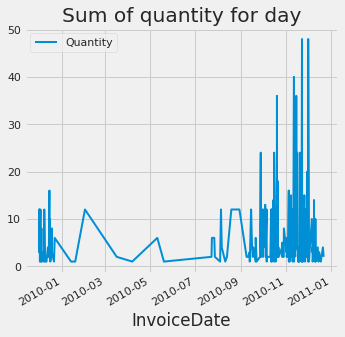

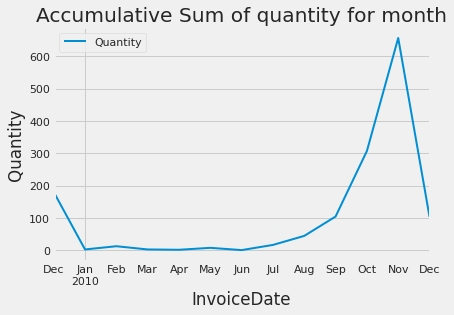

Stock_code 79323P


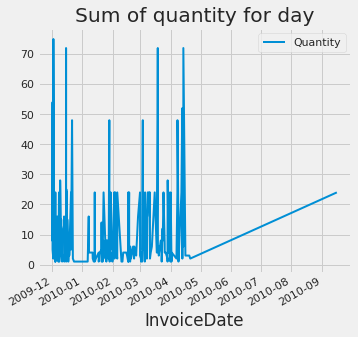

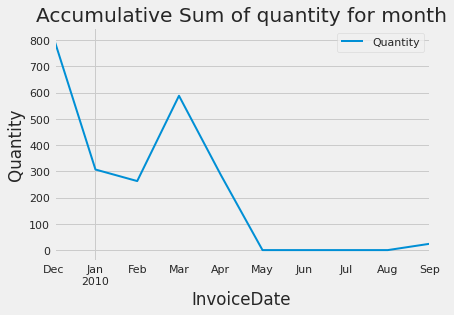

Stock_code 79323W


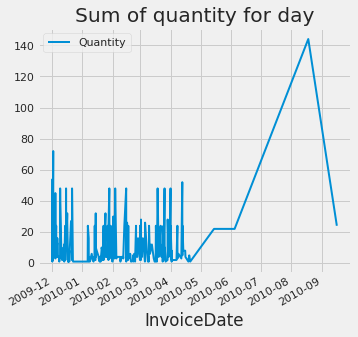

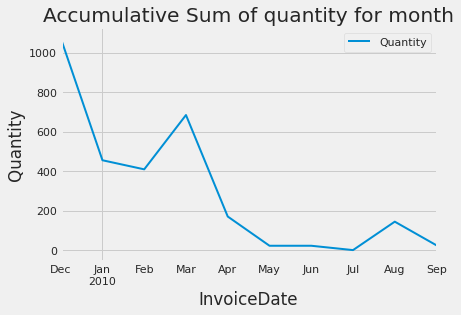

Stock_code 22041


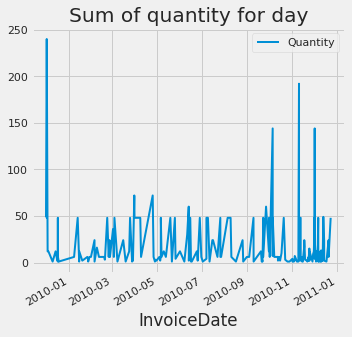

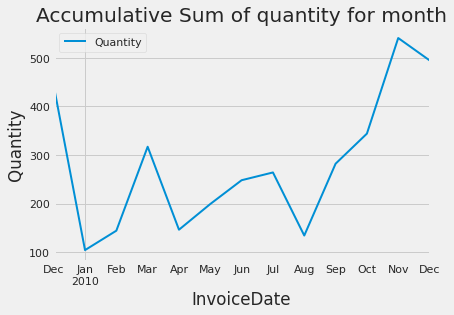

Stock_code 21232


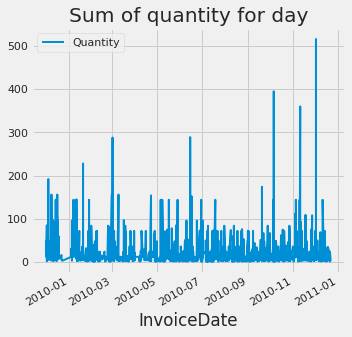

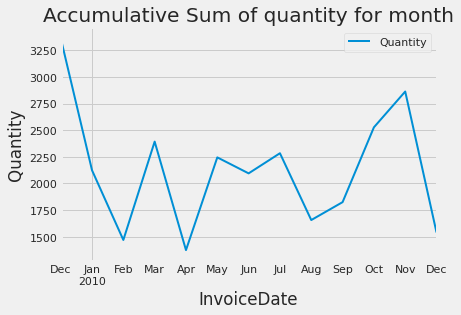

In [78]:
for code in stock_code_10[:5]:
  data = products_dict_10[code][['Quantity']].groupby(['InvoiceDate']).sum()
  print('Stock_code',code)
  date_plot(data)

Defining helper functions for splitting the mini data frames:

In [79]:
def split_product(stockcode):
      columns = ['avg_price', 'is_uk','is_christmas','is_bf','is_cm','dayofweek','quarter','month',
                                'dayofyear','dayofmonth','weekofyear','season', 'part_of_day','mean_3h','mean_9h','mean_30h']
      X_train, y_train = products_dict_10[stockcode][columns] ,products_dict_10[stockcode]['Quantity']
      X_test, y_test = products_dict_11[stockcode][columns] ,products_dict_11[stockcode]['Quantity']
      return X_train, y_train, X_test, y_test

In [80]:
def pre_train_nn(stock_code):
      X_train, y_train, X_test, y_test = split_product(stock_code)
      X_train_nn, X_val_nn, Y_train_nn, Y_val_nn = \
          train_test_split(X_train, y_train, train_size = 0.8, random_state = 42)
      # scale_data_train(X_train_nn, X_train_nn.select_dtypes(include='number'), min_max_scaler)
      # scale_data_test(X_val_nn, X_val_nn.select_dtypes(include='number'), min_max_scaler)
      X_test_nn = X_test.copy()
      # scale_data_test(X_test_nn, X_test_nn.select_dtypes(include='number'), min_max_scaler)
      return X_train_nn, X_val_nn, Y_train_nn, Y_val_nn, X_test_nn, y_test

Creating dictionaries for saving the mini data frames results:

In [81]:
rmse_product_dic_xgb = {}
rmse_product_dic_fc = {}
rmse_product_dic_lstm = {}

mae_product_dic_xgb = {}
mae_product_dic_fc = {}
mae_product_dic_lstm = {}

Defining a helper function for training each product:

In [82]:
def train_stock_code(stock_code, model, model_name):
  X_train, y_train, X_test, y_test = split_product(stock_code)
  if model == 'XGBoost':
    rmse = train_xgb(X_train, y_train, X_test, y_test, model_name, stock_code)
    print('finished train_xgb for stock_code: ', stock_code)
    rmse_product_dic_xgb[stock_code] = rmse
  else: 
    X_train_nn, X_val_nn, Y_train_nn, Y_val_nn, X_test_nn, y_test_nn = pre_train_nn(stock_code)
    run_model(model, X_train_nn, Y_train_nn, X_val_nn, Y_val_nn, model_name)

Training and loading XGB

In [83]:
# model = 'XGBoost'
# length = len(products_dict_10.keys())
# print(length)
# name = "xgb_mini_"
# for i in range(1660, 3319):
#   train_stock_code(list(products_dict_10.keys())[i], model, "mini_data/XGB/"+name+str(i)+".txt")
#   print("finished ", i, "out of ", 1660)

In [ ]:
model = 'XGBoost'
length = len(products_dict_10.keys())
print(length)
name = "xgb_mini_"
keyslist=list(products_dict_10.keys())
for i in range(0, 1660):
  stockcode=keyslist[i]
  X_train, y_train, X_test, y_test = split_product(stockcode)
  rmse_product_dic_xgb[stockcode], mae_product_dic_xgb[stockcode] = load_xgb("mini_data/"+ name + str(i)+".txt",X_test,y_test,stockcode)
  print("finished ", i, "out of ", 1660)

for i in range(1660, length):
  stockcode=keyslist[i]
  X_train, y_train, X_test, y_test = split_product(stockcode)
  rmse_product_dic_xgb[stockcode], mae_product_dic_xgb[stockcode] = load_xgb("mini_data/XGB/"+ name + str(i)+".txt",X_test,y_test,stockcode)
  print("finished ", i, "out of ", length)

Training and loading LSTM

In [85]:
# # model ='NN'
# i = 0
# length = len(products_dict_10.keys())
# print(length)
# name = "LSTM_mini_"
# for i in range(1500, 2500):
#   train_stock_code(list(products_dict_10.keys())[i], lstm_model, "LSTM_mini/600/"+name+str(i))
#   print("finished ", i, "out of ", 1660)
#   i+=1

In [ ]:
model = 'LSTM'
length = len(products_dict_10.keys())
print(length)
name = "LSTM_mini_"
keyslist=list(products_dict_10.keys())
for i in range(0, 600):
  file_exists = exists('/content/drive/MyDrive/DeepLearningProject/Project/nn_models/LSTM_mini/'+ name + str(i)+".h5")
  if not file_exists:
    if len(products_dict_10[keyslist[i]]) == 1 :
      continue 
    train_stock_code(list(products_dict_10.keys())[i], lstm_model, "LSTM_mini/"+name+str(i))
  stockcode=keyslist[i]
  X_train_nn, X_val_nn, Y_train_nn, Y_val_nn, X_test_nn, y_test_nn = pre_train_nn(stockcode)
  rmse_product_dic_lstm[stockcode], mae_product_dic_lstm[stockcode] = load_nn(lstm_model,X_test_nn,y_test_nn,'LSTM_mini/'+ name + str(i),stockcode)
  print("finished ", i, "out of ", 600)

for i in range(600, 2673):
  file_exists = exists('/content/drive/MyDrive/DeepLearningProject/Project/nn_models/LSTM_mini/600/'+ name + str(i)+".h5") 
  if not file_exists:
    if len(products_dict_10[keyslist[i]]) == 1 :
      continue 
    train_stock_code(list(products_dict_10.keys())[i], lstm_model, "LSTM_mini/600/"+name+str(i))
  stockcode=keyslist[i]
  X_train_nn, X_val_nn, Y_train_nn, Y_val_nn, X_test_nn, y_test_nn = pre_train_nn(stockcode)
  rmse_product_dic_lstm[stockcode], mae_product_dic_lstm[stockcode] = load_nn(lstm_model,X_test_nn,y_test_nn,'LSTM_mini/600/'+ name + str(i),stockcode)
  print("finished ", i, "out of ", 2673)

for i in range(2673, length):
  file_exists = exists('/content/drive/MyDrive/DeepLearningProject/Project/nn_models/LSTM_mini/2673/'+ name + str(i)+".h5") 
  if not file_exists:
    if len(products_dict_10[keyslist[i]]) == 1 :
      continue 
    train_stock_code(list(products_dict_10.keys())[i], lstm_model, "LSTM_mini/2673/"+name+str(i))
  stockcode=keyslist[i]
  X_train_nn, X_val_nn, Y_train_nn, Y_val_nn, X_test_nn, y_test_nn = pre_train_nn(stockcode)
  rmse_product_dic_lstm[stockcode], mae_product_dic_lstm[stockcode] = load_nn(lstm_model,X_test_nn,y_test_nn,'LSTM_mini/2673/'+ name + str(i),stockcode)
  print("finished ", i, "out of ", length)

Training and loading FC

In [88]:
# model ='NN'
# i = 0
# length = len(products_dict_10.keys())
# print(length)
# name = "FC_mini_"
# for i in range(2200,2600):
#   train_stock_code(list(products_dict_10.keys())[i], fc_model, "FC_mini/1000+/"+name+str(i))
#   print("finished ", i, "out of ", 400)
#   i+=1

In [ ]:
model = 'FC'
length = len(products_dict_10.keys())
print(length)
name = "FC_mini_"
keyslist=list(products_dict_10.keys())
for i in range(0, 1000):
  if len(products_dict_10[keyslist[i]]) == 1 :
    continue 
  stockcode=keyslist[i]
  X_train_nn, X_val_nn, Y_train_nn, Y_val_nn, X_test_nn, y_test_nn = pre_train_nn(stockcode)
  rmse_product_dic_fc[stockcode], mae_product_dic_fc[stockcode] = load_nn(fc_model,X_test_nn,y_test_nn,'FC_mini/'+ name + str(i),stockcode)
  print("finished ", i, "out of ", 1000)

for i in range(1000, 3000):
  if len(products_dict_10[keyslist[i]]) == 1 :
    continue 
  stockcode=keyslist[i]
  X_train_nn, X_val_nn, Y_train_nn, Y_val_nn, X_test_nn, y_test_nn = pre_train_nn(stockcode)
  rmse_product_dic_fc[stockcode], mae_product_dic_fc[stockcode] = load_nn(fc_model,X_test_nn,y_test_nn,'FC_mini/1000+/'+ name + str(i),stockcode)
  print("finished ", i, "out of ", 3000)

for i in range(3000, length):
  if len(products_dict_10[keyslist[i]]) == 1 :
    continue 
  stockcode=keyslist[i]
  X_train_nn, X_val_nn, Y_train_nn, Y_val_nn, X_test_nn, y_test_nn = pre_train_nn(stockcode)
  rmse_product_dic_fc[stockcode], mae_product_dic_fc[stockcode] = load_nn(fc_model,X_test_nn,y_test_nn,'FC_mini/3000+/'+ name + str(i),stockcode)
  print("finished ", i, "out of ", length)

Calculating mean scores for every model (of the second method):

In [175]:
rmse_dict['Mini_datas_avg_fc'] = mean(list(rmse_product_dic_fc.values()))
rmse_dict['Mini_datas_avg_xgb']  = mean(list(rmse_product_dic_xgb.values()))
rmse_dict['Mini_datas_avg_lstm']  = mean(list(rmse_product_dic_lstm.values()))

In [176]:
mae_dict['Mini_datas_avg_fc'] = mean(list(mae_product_dic_fc.values()))
mae_dict['Mini_datas_avg_xgb']  = mean(list(mae_product_dic_xgb.values()))
mae_dict['Mini_datas_avg_lstm']  = mean(list(mae_product_dic_lstm.values()))

### **Final comparison and Results**

In [177]:
errors_df = pd.DataFrame.from_dict(rmse_dict, orient='index', columns=['RMSE'])
errors_df['MAE'] = pd.DataFrame.from_dict(mae_dict, orient='index')

In [178]:
errors_df

,RMSE,MAE
Whole_data_xgb,2216.530036,1767.590293
Whole_data_FC,1409.062040,811.172617
Whole_data_LSTM,3002.780567,1093.749036
Mini_datas_avg_fc,107.324559,65.740315
Mini_datas_avg_xgb,35.061068,21.373068
Mini_datas_avg_lstm,5642.153789,987.224030


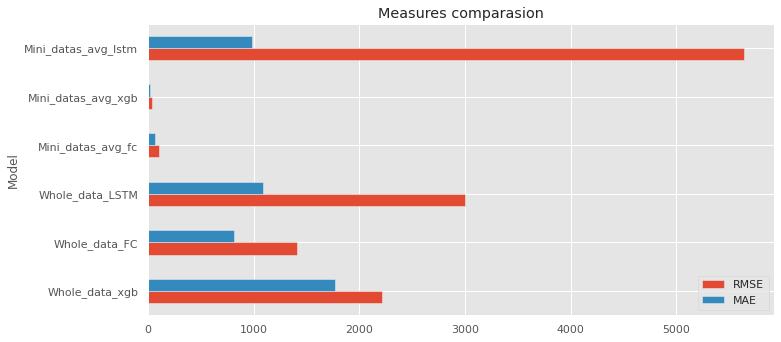

In [179]:
ax = errors_df.plot(kind="barh", rot=0,figsize=(10,5), title = "Measures comparasion", xlabel = "Model")

 From the results we can see that for the first working method, the FC model produced the minimum error for both metrics. For the second method, and across all models and methods,  the XGB model got the least of the errors.


**Mini Models Predictions Visualizations by Models Types**

Find the stock code with the highest rmse for each model: 

In [180]:
def find_key_max(dict1, dict2):
  new_dict = {}
  for key in dict1.keys():
    if dict1[key].shape > (500,20) : 
      new_dict[key] = dict2[key]
  return max(new_dict, key=new_dict.get)

In [181]:
lstm_key_max=find_key_max(predictions_mini_datas_lstm,rmse_product_dic_lstm)
fc_key_max=find_key_max(predictions_mini_datas_fc,rmse_product_dic_fc)
xgb_key_max=find_key_max(predictions_mini_datas_xgb,rmse_product_dic_xgb)

In [182]:
def present_comparsion(xgb_key, lstm_key, fc_key):
  sns.set()
  plt.style.use('ggplot')
  f, ax = plt.subplots(3, 1)
  f.set_figheight(10)
  f.set_figwidth(10)

  X_train, y_train, X_test, y_test = split_product(xgb_key)
  ax[2].set_title('Comparision between XGBoost predictions for mini product and real values')
  ax[2].set(ylim=(0,3000))
  ax[2].plot(y_test.index, y_test, ls='-', c='black',
          label='Observed data points')
  ax[2].plot(y_test.index, predictions_mini_datas_xgb[xgb_key], ls='-', c='#0072B2', label='Forecast')

  X_train_nn, X_val_nn, Y_train_nn, Y_val_nn, X_test_nn, y_test_nn = pre_train_nn(lstm_key)
  ax[0].set_title('Comparision between LSTM predictions for mini product and real values')
  ax[0].set(ylim=(0,3000))
  ax[0].plot(y_test_nn.index, y_test_nn, ls='-', c='black',
          label='Observed data points')
  ax[0].plot(y_test_nn.index, predictions_mini_datas_lstm[lstm_key], ls='-', c='#0072B2', label='Forecast')

  X_train_nn, X_val_nn, Y_train_nn, Y_val_nn, X_test_nn, y_test_nn = pre_train_nn(fc_key)
  ax[1].set_title('Comparision between FC predictions for mini product and real values')
  ax[1].set(ylim=(0,3000))
  ax[1].plot(y_test_nn.index, y_test_nn, ls='-', c='black',
          label='Observed data points')
  ax[1].plot(y_test_nn.index, predictions_mini_datas_fc[fc_key], ls='-', c='#0072B2', label='Forecast')


  plt.tight_layout()

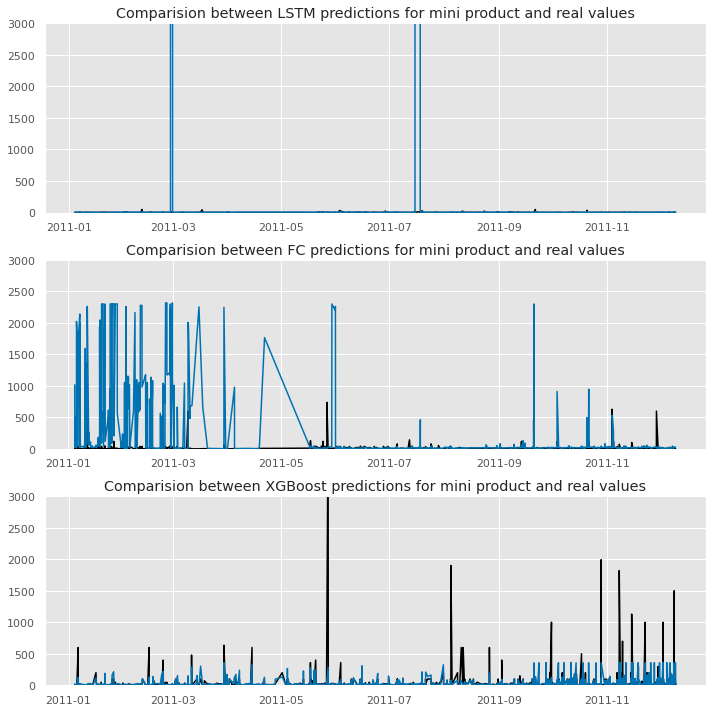

In [183]:
present_comparsion(xgb_key_max, lstm_key_max, fc_key_max)

Find the stock code with the closest rmse to the mean for each model: 

In [186]:
def find_key_avg(mean_score, dict1, dict2):
  new_dict = {}
  for key in dict1.keys():
    if dict1[key].shape > (500,20) : 
      new_dict[key]=dict2[key]
  return min(new_dict, key = lambda key: abs(new_dict[key] - mean_score))

In [187]:
lstm_key_mean=find_key_avg(rmse_dict['Mini_datas_avg_lstm'],predictions_mini_datas_lstm, rmse_product_dic_lstm)
fc_key_mean=find_key_avg(rmse_dict['Mini_datas_avg_fc'],predictions_mini_datas_fc, rmse_product_dic_fc)
xgb_key_mean=find_key_avg(rmse_dict['Mini_datas_avg_xgb'], predictions_mini_datas_xgb, rmse_product_dic_xgb)

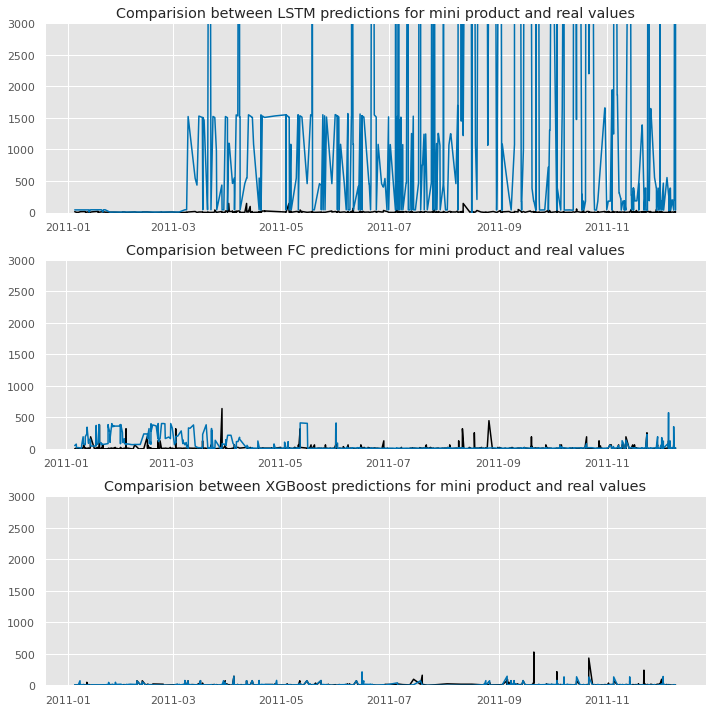

In [188]:
present_comparsion(xgb_key_mean, lstm_key_mean, fc_key_mean)

**Whole data Predictions Visualizations by Models Types**

In [189]:
X_train, y_train = df10_copy[columns] ,df10_copy['Quantity']
X_test, y_test = df11_copy[columns] ,df11_copy['Quantity']

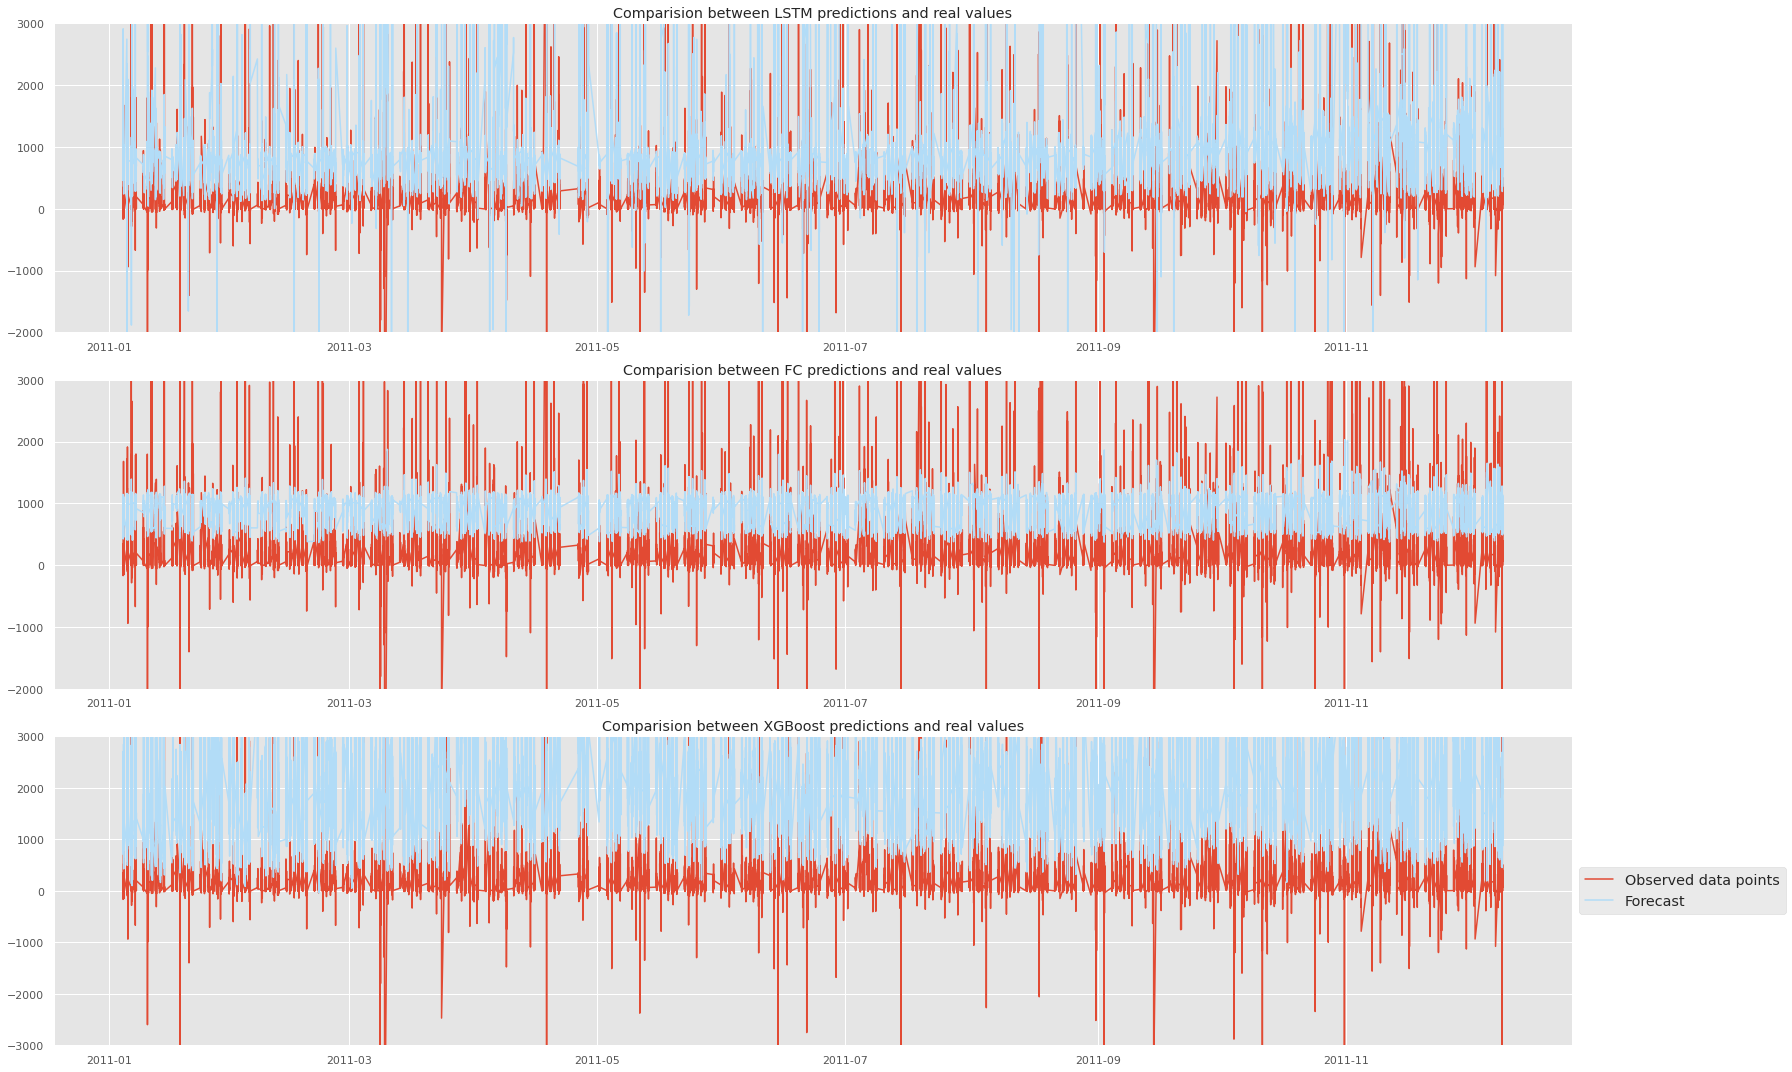

In [190]:
sns.set()
plt.style.use('ggplot')

f, ax = plt.subplots(3)
f.set_figheight(15)
f.set_figwidth(25)

ax[0].set_title('Comparision between LSTM predictions and real values')
ax[0].set(ylim=(-2000,3000))
ax[0].plot(y_test.index, y_test, ls='-',
        label='Observed data points')
ax[0].plot(y_test.index, predictions_whole_data['Whole_data_lstm_model'], ls='-', c='#b2dcf7', label='Forecast')

ax[1].set_title('Comparision between FC predictions and real values')
ax[1].set(ylim=(-2000,3000))
ax[1].plot(y_test.index, y_test, ls='-', 
        label='Observed data points')
ax[1].plot(y_test.index, predictions_whole_data['Whole_data_FC'], ls='-', c='#b2dcf7', label='Forecast')

ax[2].set_title('Comparision between XGBoost predictions and real values')
ax[2].set(ylim=(-3000,3000))
ax[2].plot(y_test.index, y_test, ls='-',
        label='Observed data points')
ax[2].plot(y_test.index, predictions_whole_data['Whole_data_xgb'], ls='-', c='#b2dcf7', label='Forecast')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize="x-large")


plt.tight_layout()

Overall from all plots of the two methods we can see that the XGB predicted better for year 2011. <br> 
In addition, the models in the second method (mini datas) produced better predictions comparing to the first method (whole data).

#### **Conclusion:**
It can be seen from the results that on the one hand the prediction of the second method is better for two of the three models (XGB, FC), therefore it can be concluded that organizing and arranging the data in a way that reduces noise can help the model learn better. However, preparing the data for the second method took a lot of resources (time, memory) , therefore it is important to take this parameter into account as well.
On the other hand, for the first method, the FC model predicted better than the other two models, therefore, another conclusion can be that it is very important to match the training data to the type of model.